# Problem Statement- Creating model to accurately predict used car price based on given features

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

 # importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import pickle




In [ ]:
cdata= pd.read_csv("../input/vehicle-dataset-from-cardekho/car data.csv")

cdata.head()

In [ ]:
cdata.shape

In [ ]:
cdata.info()

In [ ]:
cdata.describe()

### Checking Null values

In [ ]:
cdata.isnull().sum()

### we are predicting selling price of car  based on various feature that will contribute to price prediction

# EDA

### Converting Year in age of car

In [ ]:
x = datetime.datetime.now()
cdata['car_age']=x.year-cdata['Year']

cdata.drop('Year',axis=1,inplace=True)
cdata.head()

In [ ]:

plt.figure(figsize=(10,8))
ax =sns.countplot(cdata.Fuel_Type )
for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+1))

### Almost 70% are petrol cars

In [ ]:
plt.figure(figsize=(10,8))
ax =sns.countplot(cdata.Transmission)
for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+1))

In [ ]:
k=cdata.Seller_Type.value_counts()
fig, ax = plt.subplots(figsize=(7,7))
labels = ['Dealer', 
         'Individual']
percentages = [k[0], k[1]]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.0f%%', 
       shadow=False, startangle=90,   
       pctdistance=1.2,labeldistance=1.4)
ax.set_title("No of sellers Individual vs Dealer")


In [ ]:
sns.catplot(data=cdata,x='Fuel_Type' ,y='Selling_Price',kind='point',hue='Transmission')

### Selling price of diesel car with automatic transmission are high compare to automatic petrol, even manual transmission show high price for diesel type car

In [ ]:
sns.catplot(data=cdata,x='Transmission' ,y='Selling_Price',kind='point',hue='Seller_Type')

### Price of cars where dealer is selling are high , as when we buy from dealer we are assured of good used car as maintenance being done by dealer


In [ ]:
sns.regplot(data=cdata,x='Present_Price' ,y='Selling_Price')


In [ ]:

sns.regplot(data=cdata,x='Kms_Driven' ,y='Selling_Price')

In [ ]:
sns.barplot('Owner','Selling_Price',data=cdata,palette='ocean')

### Selling price of first owner car  price is high also its shows less spread of price 

In [ ]:
plt.figure(figsize=(10,5))
sns.catplot('car_age','Selling_Price',data=cdata, kind='swarm')

### Less age car have high selling price

In [ ]:
sns.pairplot(cdata)

In [ ]:
sns.heatmap(cdata.corr(),cmap='viridis',annot=True)

In [ ]:
cdata.head()


## Creating Dummy variable

In [ ]:
dummy=pd.get_dummies(cdata[['Fuel_Type','Seller_Type','Transmission']],drop_first=True)
cdummy=pd.concat([cdata,dummy],axis=1)
cdummy.head()

In [ ]:
cdummy=cdummy.drop(['Fuel_Type','Seller_Type','Transmission'],axis=1)


In [ ]:
cdummy=cdummy.drop(['Car_Name'],axis=1)

y=cdummy['Selling_Price']

In [ ]:
cdummy.columns

In [ ]:
X=cdummy[['Present_Price', 'Kms_Driven', 'Owner', 'car_age',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Seller_Type_Individual',
       'Transmission_Manual']]

## Test -train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [ ]:
scaler = StandardScaler()

X_train[['Present_Price', 'Kms_Driven', 'Owner', 'car_age']] = scaler.fit_transform(X_train[['Present_Price', 'Kms_Driven', 'Owner', 'car_age']])
X_train.head()

## Modeling
 ### - Modeling using statsmodel
 ### - Checking P value for significance and R2
 ### - using VIF to check for correlation and eliminating features with high p value or VIF

In [ ]:
X_train_sm=sm.add_constant(X_train)

lr=sm.OLS(y_train,X_train_sm)

lr_model=lr.fit()

lr_model.summary()

In [ ]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

In [ ]:
### removing Fuel_type_petrol as High P value and VIF is also high
X_train=X_train.drop(['Fuel_Type_Petrol'],axis=1)

In [ ]:
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.summary()

In [ ]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

In [ ]:
### removing Owner as High P value 
X_train=X_train.drop(['Owner'],axis=1)

In [ ]:
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.summary()

In [ ]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

In [ ]:
### removing Kms_Driven as High P value 
X_train=X_train.drop(['Kms_Driven'],axis=1)

In [ ]:
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.summary()

In [ ]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

In [ ]:
X_train.columns

### All below feature- 'Present_Price', 'car_age', 'Fuel_Type_Diesel', 'Seller_Type_Individual','Transmission_Manual' are significant to predict selling price with p values at 0  and R2 of 89.4%

## Prediction on training set


In [ ]:
y_train_pred=lr_model.predict(X_train_sm)

## Residual Analysis

In [ ]:
res=y_train-y_train_pred
sns.distplot(res)

### Residual are normally distributed that is all error terms are normally distributed

## Making prediction on test set

In [ ]:
scaler = StandardScaler()

X_test[['Present_Price', 'Kms_Driven', 'Owner', 'car_age']] = scaler.fit_transform(X_test[['Present_Price', 'Kms_Driven', 'Owner', 'car_age']])
X_test.head()

In [ ]:
col=X_train.columns
col

In [ ]:
X_test=X_test[col]

X_test_sm=sm.add_constant(X_test)


y_test_pred=lr_model.predict(X_test_sm)

r2_score(y_true=y_test, y_pred=y_test_pred)

In [ ]:
sns.regplot(y_test ,y_test_pred)

### Model learn on training is able to learn on test set  as training set R2 was 89.4% whereas test set R2 is 87.4%. present price is important feature with high  co eff which effect price prediction much more than other features

## Modeling Using SKLearn

In [ ]:
reg=linear_model.LinearRegression()

reg.fit(X_train,y_train)

reg.score(X_train,y_train)






In [ ]:
y_testPred=reg.predict(X_test)


In [ ]:
res=y_test-y_testPred
sns.distplot(res)

In [ ]:
reg.score(X_test,y_test)

### Using pickle to put model in to file for implementationusing flask on Heroku
   with open('LR.pkl','wb')as pickle_file:
          pickle.dump(reg,pickle_file)

complete set of filled on https://github.com/pratikmungekar5/CarPriceLR
Heroku App link- https://car-price-predictor-lr.herokuapp.com/

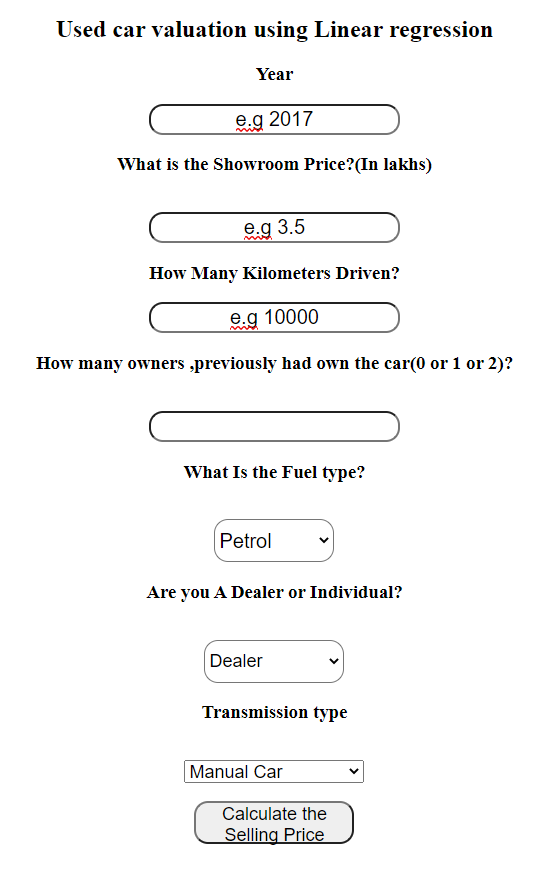